# First experiments in Sambuca minimisation with Scipy

##Set up the environment:

In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize, basinhopping
import sambuca as sb
import matplotlib.pyplot as plt
from pkg_resources import resource_filename
from scipy.io import loadmat

# set some controls on numpy formatting
# 5 decimal places, suppress scientific notation
np.set_printoptions(precision=5, suppress=True)

# set the matplotlib style to emulate ggplot2 from R
plt.style.use('ggplot')
plot_width = 12
plot_height = plot_width * 3/4

# spectra to plot
plot_items = list()

## Utility functions

In [12]:
def print_parameters(p):
    print('CHL:  {0:10.5f}\nCDOM: {1:10.5f}\nTR:   {2:10.5f}\nH:    {3:10.5f}\nQ:    {4:10.5f}'
          .format(p[0],p[1],p[2],p[4],p[3]))
    
def evaluate_forward_model(p, siops, sensor_filter):
    spectra = sb.forward_model(
        chl = p[0],
        cdom = p[1],
        nap = p[2],
        depth = p[4],
        substrate_fraction = p[3],
        substrate1=siops['substrate1'],
        substrate2=siops['substrate2'],
        wav=siops['wav'],
        awater=siops['awater'],
        aphy_star=siops['aphy_star'],
        num_bands=siops['d_wls'])
        
    # Apply the sensor filter and return the results
    return sb.apply_sensor_filter(spectra.rrs, sensor_filter)

##Load the matlab reference data:

In [3]:
filename = resource_filename(
            sb.__name__,
            'tests/data/test_optimise_data.mat')
data = loadmat(filename, squeeze_me=True)
data.keys()

dict_keys(['__header__', 'p_max', 'modelled_spectra', 'p_min', '__version__', 'observed_spectra', '__globals__', 'p'])

The order of parameters in p, p_min, and p_max are :
    
    CHL, CDOM, TR, Q, H
        
Grab the final parameters and boundary values:

In [4]:
matlab_final_parameters = data['p']
p_min = data['p_min']
p_max = data['p_max']
print("Matlab Parameters")
print_parameters(matlab_final_parameters)

Matlab Parameters
CHL:     0.13047
CDOM:    0.00372
TR:      0.59454
H:      10.44262
Q:       0.13181


While we are at it, plot the observed and final modelled spectra from the Matlab run:

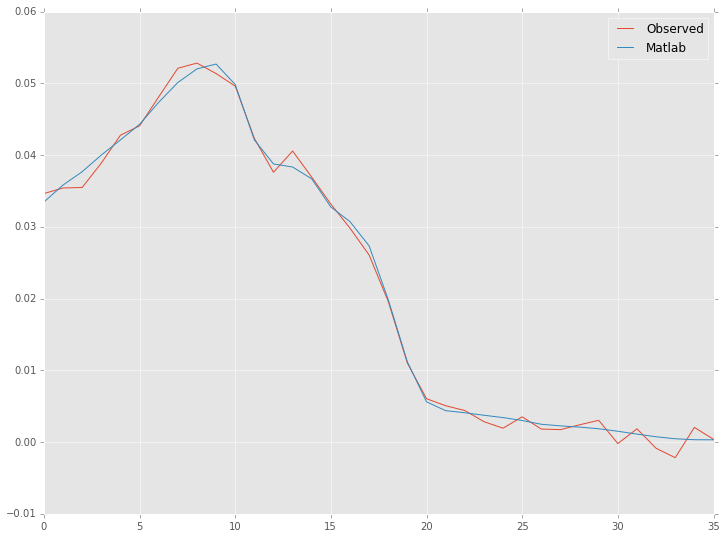

In [5]:
obs_spectra = data['observed_spectra']
mdl_spectra = data['modelled_spectra']
plot_items.clear()
plot_items.append((obs_spectra, 'Observed'))
plot_items.append((mdl_spectra, 'Matlab'))

plt.figure(figsize=(plot_width, plot_height))
for pi in plot_items:
    plt.plot(pi[0], label=pi[1])
plt.legend(loc='upper right')
plt.show()

## Load the sambuca model inputs (SIOPS)

In [10]:
filename = '../QBdata/forwardModelTestValues.mat'
siops_data = loadmat(filename, squeeze_me=True)
print(siops_data.keys())

filename = resource_filename(
            sb.__name__,
            'tests/data/test_resample.mat')
sensor_data = loadmat(filename, squeeze_me=True)
print()
print(sensor_data.keys())

print()
print(sensor_data['filt'].shape)

dict_keys(['tr', '__header__', 'substrate1', 'chl', 'substrate2', 'h', '__globals__', 'modelled_spectra', '__version__', 'd_wls', 'awater', 'cdom', 'UQSubs', 'wav', 'aphy_star', 'q', 'n_wls'])

dict_keys(['filt', 'bandsum', '__header__', 'filtsum', '__version__', 'modelled_spectra', '__globals__', 'resampled_spectra', 'calc'])

(551, 36)


In [11]:
# the noise data happens to be in a different file
filename = resource_filename(sb.__name__, 'tests/data/test_error_noise.mat')
noise_data = loadmat(filename, squeeze_me=True)

## Objective Function
Define the objective function by assembling sambuca components (forward model, sensor filter, error function), using a closure to bind the other inputs:

In [13]:
import math

def make_objective(siops, sensor_filter, obs_spectra, p_bounds=None, noise=None):
    awater = siops['awater']
    wav = siops['wav']
    aphy_star = siops['aphy_star']
    substrate1 = siops['substrate1']
    substrate2 = siops['substrate2']
    num_modelled_bands = siops['d_wls']
    num_observed_bands = siops['n_wls']
            
    def objective(p):
        # To support algorithms without support for boundary values, we assign a high 
        # score to out of range parameters.
        # p_bounds is a tuple of (min, max) pairs for each parameter in p
        if p_bounds is not None:
            for _p, lu in zip(p, p_bounds):
                l, u = lu
                if _p < l or _p > u:
                    return 100000.0
                    
        # call the forward model
        # We rely on the default values of the other model inputs, which happen to be
        # the same values used in the Matlab code
        spectra = sb.forward_model(
            chl = p[0],
            cdom = p[1],
            nap = p[2],
            depth = p[4],
            substrate_fraction = p[3],
            substrate1=substrate1,
            substrate2=substrate2,
            wav=wav,
            awater=awater,
            aphy_star=aphy_star,
            num_bands=num_modelled_bands)
        
        # Apply the sensor filter
        filtered_spectra = sb.apply_sensor_filter(spectra.rrs, sensor_filter)
        
        # Calculate the error and return it as the objective score
        error = sb.error_all(obs_spectra, filtered_spectra, noise)
        
        #return error.alpha
        #return error.alpha_f
        return error.f
        #return error.lsq
    
    return objective

Define the initial values and boundary values, even though not all minimisation methods support constraints:

In [14]:
#p_min and p_max have already been defined in previous cells (read from test data)
# random parameters often lead to a tougher optimisation challenge
p0_rand = np.random.random(5) * (p_max - p_min) + p_min

# Parameters known to lead Nelder-Mead astray:
#p0 = np.array([0.13959, 0.00361,  0.73770,  0.07821,  0.02446])

# Try using the matlab parameters as the initial guess:
#p0 = matlab_final_parameters * 1.5

p0 = p0_rand

# Q seems hard to estimate, so experiment with different starting values
p0[3] = 0.17

print("Initial Parameters\n")
print_parameters(p0)

# repackage p_min and p_max into the tuple of (min,max) pairs expected by our objective function,
# and by the minimisation methods that support bounds
p_bounds = tuple(zip(p_min, p_max))
print('\nBounds = {}'.format(p_bounds))

Initial Parameters

CHL:     0.19211
CDOM:    0.00535
TR:      1.80533
H:      15.95879
Q:       0.17000

Bounds = ((0.01, 0.22), (0.00050000000000000001, 0.014999999999999999), (0.20000000000000001, 2.3999999999999999), (0.0, 1.0), (0.0, 17.399999999999999))


Load the noise data:

In [15]:
# the noise data happens to be in a different file
filename = resource_filename(sb.__name__, 'tests/data/test_error_noise.mat')
noise_data = loadmat(filename, squeeze_me=True)

# With noise:
obj = make_objective(siops_data, sensor_data['filt'], obs_spectra, noise_data['noiserrs'])
# Without noise:
#obj = make_objective(siops_data, sensor_data['filt'], obs_spectra)

#Optimisation using SciPy

More info on the different methods:
http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html

## Nelder-Mead (method='nelder-mead')
This is the closest match to the Amoeba algorithm used in the IDL code, but it does not support constraints on the parameters. Constraints can be simulated by checking for out of range values in the objective function and assigning an arbitrarily high score.

**Note that if the function fails to converge (max iterations exceeded), it is worth regenerating p0**

In [16]:
# construct an objective value with handling for parameter boundaries
obj_bounds = make_objective(
        siops_data, 
        sensor_data['filt'].transpose(), 
        obs_spectra, 
        p_bounds,
        noise_data['noiserrs'])

# call the minimiser
res_nm = minimize(obj_bounds, p0, method='nelder-mead', 
                  options={'xtol':1e-5, 'disp':True, 'maxiter':50000})

p_nm = res_nm['x']
print_parameters(p_nm)

nm_spectra = evaluate_forward_model(p_nm, siops_data, sensor_data['filt'].transpose())

Optimization terminated successfully.
         Current function value: 0.013100
         Iterations: 439
         Function evaluations: 767
CHL:     0.17859
CDOM:    0.00451
TR:      1.00751
H:      17.39987
Q:       0.00000


## Other Unconstrained Methods (objective function applies constraints)

In [17]:
res_powell = minimize(obj_bounds, p0, method='L-BFGS-B', options={'disp':True, 'maxiter':20000})
p_powell = res_powell['x']
print_parameters(p_powell)
powell_spectra = evaluate_forward_model(p_powell, siops_data, sensor_data['filt'].transpose())

CHL:     0.21997
CDOM:    0.01131
TR:      1.75666
H:      15.95893
Q:       0.17086


In [18]:
res_bfgs = minimize(obj_bounds, p0, method='BFGS', options={'disp':True, 'maxiter':20000})
p_bfgs = res_bfgs['x']
print_parameters(p_bfgs)
bfgs_spectra = evaluate_forward_model(p_bfgs, siops_data, sensor_data['filt'].transpose())

         Current function value: 0.064529
         Iterations: 2
         Function evaluations: 295
         Gradient evaluations: 41
CHL:     0.21327
CDOM:    0.00845
TR:      1.76649
H:      15.95890
Q:       0.17053


In [19]:
res_cobyla = minimize(obj_bounds, p0, method='COBYLA', 
                      options={'disp':True, 'maxiter':20000})
p_cobyla = res_cobyla['x']
print_parameters(p_cobyla)
cobyla_spectra = evaluate_forward_model(p_cobyla, siops_data, sensor_data['filt'].transpose())

CHL:     0.19725
CDOM:    0.01233
TR:      1.76039
H:      17.08285
Q:       0.15943


##Methods that handle boundary values (objective function has no bounds)

In [20]:
# construct an objective without boundary values
obj_nobounds = make_objective(
        siops_data, 
        sensor_data['filt'].transpose(), 
        obs_spectra, 
        None,
        noise_data['noiserrs'])

In [21]:
res_lbfgs = minimize(obj_nobounds, p0, method='L-BFGS-B', bounds=p_bounds, 
                     options={'disp':True, 'maxiter':20000})
p_lbfgs = res_lbfgs['x']
print_parameters(p_lbfgs)
lbfgs_spectra = evaluate_forward_model(p_lbfgs, siops_data, sensor_data['filt'].transpose())

CHL:     0.14565
CDOM:    0.00440
TR:      0.93980
H:      15.95954
Q:       0.18584


In [22]:
res_slsqp = minimize(obj_nobounds, p0, method='SLSQP', bounds=p_bounds, 
                     options={'disp':True, 'maxiter':20000})
p_slsqp = res_slsqp['x']
print_parameters(p_slsqp)
slsqp_spectra = evaluate_forward_model(p_slsqp, siops_data, sensor_data['filt'].transpose())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0119226694058
            Iterations: 16
            Function evaluations: 119
            Gradient evaluations: 16
CHL:     0.15432
CDOM:    0.00423
TR:      0.92486
H:      15.93793
Q:      -0.00000


##Global Search: Basin Hopping with SLSQP
Slower, but worth a try...

In [31]:
# basinhopping fails with any of the other error functions, at least with the current data set
bh_spectra = None
if False:
    res_bh = basinhopping(obj_nobounds, 
                          p0_rand, 
                          #T=1.0,
                          #stepsize=0.8,
                          #niter=200, 
                          #disp=True,
                          minimizer_kwargs={'method':'SLSQP', 'bounds':p_bounds, 
                                            'options':{'disp':False, 'maxiter':2000}})
    p_bh = res_bh['x']
    print_parameters(p_bh)
    bh_spectra = evaluate_forward_model(p_bh, siops_data, sensor_data['filt'].transpose())
else:
    print('Skipped')

Skipped


###Plot the results

Retrieve the best parameter set, run the forward model with those parameters and then plot the results alongside the observed spectra and Matlab results:

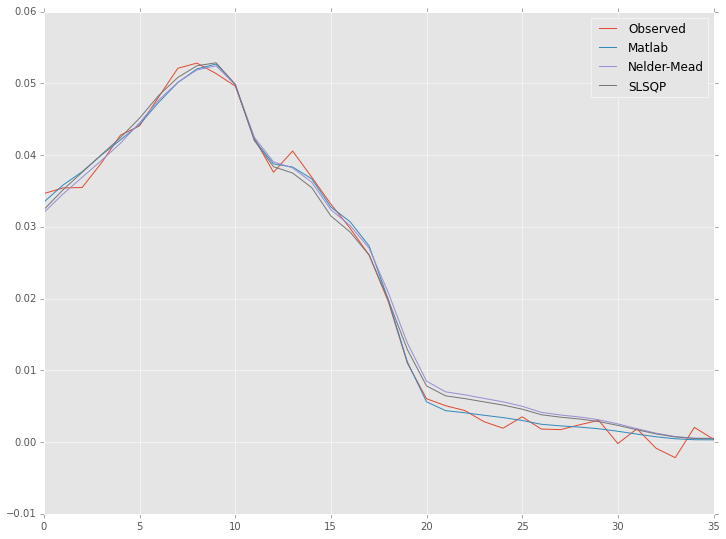

In [25]:
plot_items.clear()
plot_items.append((obs_spectra, 'Observed'))
plot_items.append((mdl_spectra, 'Matlab'))
plot_items.append((nm_spectra, 'Nelder-Mead'))
plot_items.append((slsqp_spectra, 'SLSQP'))
#plot_items.append((powell_spectra, 'Powell'))
#plot_items.append((lbfgs_spectra, 'L-BFGS-B'))
#plot_items.append((cobyla_spectra, 'COBYLA'))
#plot_items.append((bfgs_spectra, 'BFGS'))
if bh_spectra is not None:
    plot_items.append((bh_spectra, 'Basinhopping'))

plt.figure(figsize=(plot_width, plot_height))
for pi in plot_items:
    plt.plot(pi[0], label=pi[1])

plt.legend(loc='upper right')
plt.show()

## Compare the parameters

In [26]:
print("Matlab")
print_parameters(matlab_final_parameters)

print("\nSearch Start")
print_parameters(p0)

print("\nNelder-Mead")
print_parameters(p_nm)

print("\nSequential Least Squares")
print_parameters(p_slsqp)

Matlab
CHL:     0.13047
CDOM:    0.00372
TR:      0.59454
H:      10.44262
Q:       0.13181

Search Start
CHL:     0.19211
CDOM:    0.00535
TR:      1.80533
H:      15.95879
Q:       0.17000

Nelder-Mead
CHL:     0.17859
CDOM:    0.00451
TR:      1.00751
H:      17.39987
Q:       0.00000

Sequential Least Squares
CHL:     0.15432
CDOM:    0.00423
TR:      0.92486
H:      15.93793
Q:      -0.00000


# Timing Results

SLSQP (Sequential Least Squares) appears to do consistently well and is less sensitive to the initial parameters. It also requires less function evaluations on average. Comparing it to Nelder-Mead (which is the closest match to the Amoeba algorithm used in the IDL code):

In [27]:
print('Nelder-Mead Function Evaluations {:10.5f}'.format(res_nm['nfev']))
print('SLSQP Function Evaluations {:10.5f}'.format(res_slsqp['nfev']))

Nelder-Mead Function Evaluations  767.00000
SLSQP Function Evaluations  119.00000


In [28]:
print('SLSQP Time')
%timeit minimize(obj_nobounds, p0, method='SLSQP', bounds=p_bounds, options={'disp':False, 'maxiter':20000})

SLSQP Time
10 loops, best of 3: 53.6 ms per loop


In [30]:
print('Nelder-Mead Time')
%timeit minimize(obj_bounds, p0, method='nelder-mead', options={'xtol':1e-8, 'disp':False, 'maxiter':20000})

Nelder-Mead Time
1 loops, best of 3: 350 ms per loop
